<a href="https://colab.research.google.com/github/golnazads/ColabNotebooks/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install requests

In [ ]:
import requests
import json
import datetime

def get_citations(bibcode):
  # Set up the request parameters
  url = 'https://api.adsabs.harvard.edu/v1/search/query'
  headers = {'Authorization': 'Bearer:<api token here>'}
  params = {
      'q': 'bibcode:%s'%bibcode,
      'sort': 'relevance',
      'rows': 100,
      'start': 0,
      'fl': 'citation'
  }

  # Send the request and get the response
  response = requests.get(url, params=params, headers=headers)
  docs = json.loads(response.text)['response']['docs']

  citations = {}

  if len(docs) == 1:
    doc = docs[0]
    # add citations to the list
    for citation in doc.get('citation', []):
      year = int(citation[0:4])
      if not citations.get(year, None):
        citations[year] = 0
      citations[year] += 1

  # make sure current year is included
  current_year = datetime.date.today().year
  if not citations.get(current_year, None):
    citations[current_year] = 0

  # add in any missing year
  for year in (range(min(citations), max(citations))):
    if not citations.get(year, None):
      citations[year] = 0

  # sort and return counts in order descending
  sorted_citations = sorted(citations.items(), key=lambda x: (-x[0], x[1]))

  return [item[1] for item in sorted_citations]

In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from google.colab import data_table
data_table.enable_dataframe_formatter()

bibcodes = [
    '2018arXiv181004805D',
    '2018PhRvL.121p1101A',
    '2018arXiv180911096B',
    '2018PhRvL.121k1302A',
    '2018AJ....156..123A',
    '2018Quant...2...79P',
    '2018PhRvL.121h6803Y',
    '2018PhRvD..98c0001T',
    '2018AJ....156...58B',
    '2018A&A...616A...2L',
    '2018A&A...616A...1G',
    '2018arXiv180703748V',
    '2018arXiv180601261B',
    '2018ApJ...859..101S',
    '2018arXiv180402767R',
    '2018Natur.556...80C',
    '2018Natur.556...43C',
    '2018LRR....21....3A',
    '2018arXiv180302999N',
    '2018MNRAS.475..676S',
    '2018CoPhC.224..405W',
    '2018arXiv180203426M',
    '2018ApJS..234...34P',
    '2018RvMP...90a5005B',
    '2018RvMP...90a5001A',
    '2018NatSR...8....1A',
    '2018NatPh..14...11E',
    '2018NatCo...9....1M',
    '2018MNRAS.473.4077P',
]

rows = []
for bibcode in bibcodes:
  citations = get_citations(bibcode)
  if len(citations) < 6:
    citations += [0] * (6 - len(citations))
  rows.append({'bibcode': bibcode, '2023': citations[0], '2022': citations[1], '2021': citations[2], '2020': citations[3], '2019': citations[4], '2018': citations[5], 'total': sum(citations[:5])})
data = pd.DataFrame(rows)

# Convert to numpy array
X = data.iloc[:,1:].values

# Train isolation forest model
model = IsolationForest(contamination='auto')
model.fit(X)

# Get anomaly scores
data['scores'] = model.decision_function(X)

# Detect outliers
data['outlier'] = model.predict(X)

data


,bibcode,2023,2022,2021,2020,2019,2018,total,scores,outlier
0,2018arXiv181004805D,2799,2962,2322,1952,1189,59,11224,-0.274556,-1
1,2018PhRvL.121p1101A,279,341,324,286,286,49,1516,0.104791,1
2,2018arXiv180911096B,202,235,206,226,168,26,1037,0.116662,1
3,2018PhRvL.121k1302A,236,358,382,347,327,101,1650,0.092355,1
4,2018AJ....156..123A,1,1393,1279,1138,788,483,4599,-0.138975,-1
5,2018Quant...2...79P,457,447,290,152,102,64,1448,0.054609,1
6,2018PhRvL.121h6803Y,219,264,218,171,121,21,993,0.112470,1
7,2018PhRvD..98c0001T,188,390,812,1782,1413,283,4585,-0.118805,-1
8,2018AJ....156...58B,111,194,336,432,367,90,1440,0.081054,1
9,2018A&A...616A...2L,129,185,340,396,411,200,1461,0.061346,1


Text(0.5, 1.0, 'Citation Outliers')

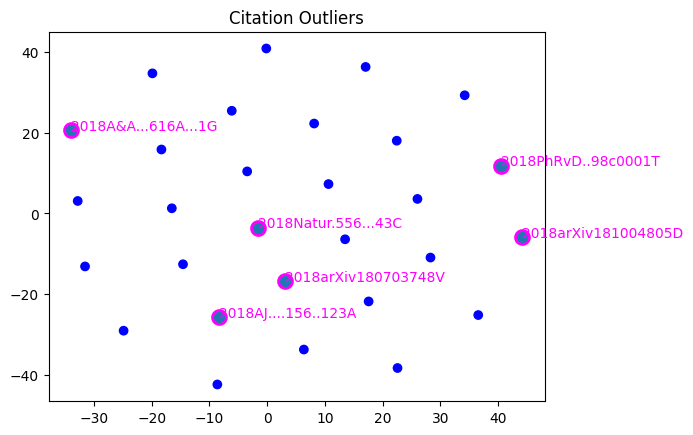

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

pred = model.predict(X)

# Create color array - outliers are red
colors = ['blue' if p == 1 else 'magenta' for p in pred]

# Use TSNE for dimensionality reduction
tsne = TSNE(perplexity=28)
transformed = tsne.fit_transform(X)

# Scatter plot with coloring
plt.figure()
plt.scatter(transformed[:,0], transformed[:,1], c=colors)

# Add labels only for outliers
for i, row in data.iterrows():
    if pred[i] == -1:
        plt.text(transformed[i,0], transformed[i,1], row['bibcode'], color='magenta')


# Highlight outliers with border
outliers = transformed[pred == -1]
plt.scatter(outliers[:,0], outliers[:,1], s=100, edgecolor='magenta', linewidth=2)

plt.title('Citation Outliers')
